In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
df_sessions = pd.read_csv('WATTS/evwatts.public.session.csv')

In [3]:
df_sessions.shape

(13937235, 11)

In [5]:
df_sessions

,session_id,evse_id,connector_id,start_datetime,end_datetime,total_duration,charge_duration,energy_kwh,start_soc,end_soc,flag_id
0,11562,5,5,2020-03-01 09:37:44,2020-03-01 11:14:59,1.621389,1.615556,6.170000,NaN,NaN,0
1,11563,116,116,2020-03-01 10:02:24,2020-03-01 11:08:14,1.096944,1.089722,5.212000,NaN,NaN,0
2,11564,72,72,2020-03-01 10:06:08,2020-03-01 11:08:10,1.033611,1.024722,3.392000,NaN,NaN,0
3,11565,1,1,2020-03-01 10:01:12,2020-03-01 11:07:09,1.099722,1.076111,6.521000,NaN,NaN,0
4,11566,0,138,2020-02-29 19:09:03,2020-03-01 10:47:16,15.636667,12.658889,80.527000,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...
13937230,14715979,27099,36881,2022-12-28 19:51:30,2022-12-29 00:30:53,4.656389,4.655556,45.023398,NaN,NaN,0
13937231,14715980,27107,36889,2022-10-17 09:32:10,2022-10-17 09:37:22,0.086667,0.710000,8.217523,NaN,NaN,0
13937232,14715981,27107,36889,2022-10-22 16:38:44,2022-10-22 22:21:32,5.713333,3.056389,10.849586,NaN,NaN,0
13937233,14715982,27107,36889,2022-10-29 15:29:15,2022-10-29 15:54:17,0.417222,0.416667,2.743180,NaN,NaN,0


In [4]:
df_evse = pd.read_csv('Data/Watts/evwatts.public.evse.csv')

In [5]:
df_evse.head(5)

,evse_id,metro_area,land_use,region,num_ports,charge_level,venue,pricing
0,6034,Undesignated,Metro Area,Mountain,1,DCFC,Corridor,Paid
1,6065,Undesignated,Metro Area,Mountain,1,DCFC,Corridor,Paid
2,6100,"Phoenix-Mesa-Chandler, AZ Metro Area",Metro Area,Mountain,1,DCFC,Undesignated,Free
3,6155,Undesignated,Metro Area,Mountain,1,DCFC,Corridor,Paid
4,1315,"Denver-Aurora-Lakewood, CO Metro Area",Metro Area,Mountain,1,DCFC,Corridor,Free


In [13]:
df_evse_sel = df_evse[(
    (df_evse['venue'] == 'Corridor') &
    (df_evse['pricing'] == 'Paid') &
    (df_evse['charge_level'] == 'DCFC') &
    (df_evse['region'] == 'Pacific')
)]

In [16]:
evse_ids = df_evse_sel['evse_id'].to_numpy()

In [83]:
df_sessions['in_sample_evse'] = df_sessions.apply(
    lambda r: r.evse_id in evse_ids, axis = 1,
)

In [72]:
df_connector = pd.read_csv('Data/Watts/evwatts.public.connector.csv')

In [73]:
df_connector.head(5)

,connector_id,evse_id,connector_number,connector_type,power_kw
0,38494,25683,1,J1772,>8 kW
1,38358,27850,1,J1772,>8 kW
2,44144,31875,1,J1772,>8 kW
3,45088,32971,1,J1772,>8 kW
4,9643,5712,1,J1772,<8 kW


In [74]:
df_connector['connector_type'].unique()

array(['J1772', 'CHAdeMO', 'Combo'], dtype=object)

In [76]:
np.unique(df_connector['power_kw'], return_counts = True)

(array(['30 kW - 100 kW', '<30 kW', '<8 kW', '>100 kW', '>8 kW',
        'Undesignated'], dtype=object),
 array([ 5478,  1623, 27134,   104, 15707,    57]))

In [77]:
df_connector_sel = df_connector[(
    (df_connector['power_kw'] == '30 kW - 100 kW') |
    (df_connector['power_kw'] == '>100 kW')
)]

In [80]:
connector_ids = df_connector_sel['connector_id'].to_numpy()

In [81]:
df_sessions['in_sample_connector'] = df_sessions.apply(
    lambda r: r.connector_id in connector_ids, axis = 1,
)

In [84]:
df_sessions_sel = df_sessions[(
    (df_sessions['in_sample_evse']) &
    (df_sessions['in_sample_connector'])
)]

In [85]:
df_sessions_sel.shape

(515976, 14)

In [86]:
pkl.dump(df_sessions_sel, open('Outputs/df_sessions_sel.pkl', 'wb'))

In [87]:
df_sessions_sel = pkl.load(open('Outputs/df_sessions_sel.pkl', 'rb'))

df_sessions_sel = df_sessions_sel[df_sessions_sel['charge_duration'] > 0]

In [88]:
df_sessions_sel.keys()

Index(['session_id', 'evse_id', 'connector_id', 'start_datetime',
       'end_datetime', 'total_duration', 'charge_duration', 'energy_kwh',
       'start_soc', 'end_soc', 'flag_id', 'in_sample', 'in_sample_connector',
       'in_sample_evse'],
      dtype='object')

In [89]:
df_sessions_sel.head(10)

,session_id,evse_id,connector_id,start_datetime,end_datetime,total_duration,charge_duration,energy_kwh,start_soc,end_soc,flag_id,in_sample,in_sample_connector,in_sample_evse
155331,162252,947,1628,2020-01-19 23:54:40,2020-01-20 00:03:07,0.140833,0.136667,5.798000,26.0,55.0,0,True,True,True
155332,162253,948,1629,2020-03-11 11:59:24,2020-03-11 12:10:45,0.189167,0.186667,8.251000,31.0,70.0,0,True,True,True
184452,223187,1579,2515,2019-11-15 16:59:15,2019-11-15 17:15:54,0.277500,0.266667,8.796000,52.0,66.0,0,True,True,True
184595,223200,1579,2516,2019-11-17 11:19:47,2019-11-17 13:58:21,2.642778,2.641111,17.853001,50.0,96.0,0,True,True,True
184596,223201,1579,2516,2019-11-17 10:35:25,2019-11-17 11:15:15,0.663889,0.660833,24.476000,47.0,89.0,0,True,True,True
184597,223202,1579,2516,2019-11-15 14:07:59,2019-11-15 14:53:51,0.764444,0.761111,17.711000,47.0,94.0,0,True,True,True
184601,223206,1580,2517,2019-11-16 16:16:32,2019-11-16 16:30:21,0.230278,0.225556,8.439000,63.0,78.0,0,True,True,True
184602,223207,1580,2517,2019-11-17 10:33:44,2019-11-17 11:44:26,1.178333,1.171111,30.152000,45.0,98.0,0,True,True,True
184603,223208,1580,2517,2019-11-14 12:07:54,2019-11-14 12:28:28,0.342778,0.338889,14.726000,25.0,52.0,0,True,True,True
184604,223209,1581,2518,2019-10-04 12:26:34,2019-10-04 12:56:18,0.495556,0.493333,20.747999,7.0,43.0,0,True,True,True


In [100]:
energy_kwh = df_sessions_sel['energy_kwh'].to_numpy()
charge_duration = df_sessions_sel['charge_duration'].to_numpy()
end_soc = df_sessions_sel['end_soc'].to_numpy()
start_soc = df_sessions_sel['start_soc'].to_numpy()

(array([49424., 88445., 98020., 85823., 69512., 52434., 33173., 17598.,
         8436.,  5912.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

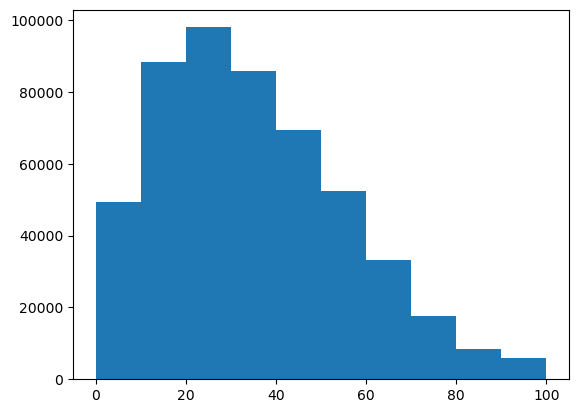

In [101]:
plt.hist(start_soc)

(array([  2238.,   5920.,  11536.,  16797.,  23803.,  34920.,  46497.,
         71706., 124065., 177236.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

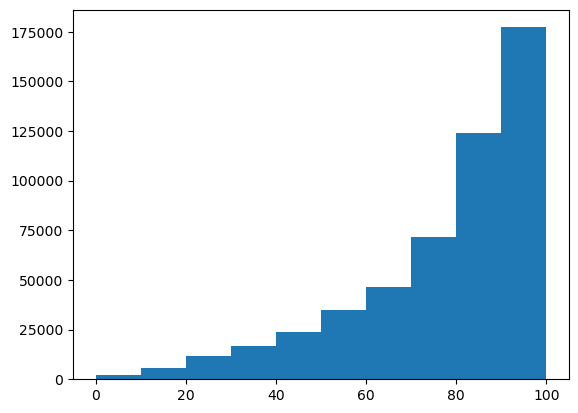

In [102]:
plt.hist(end_soc)

In [114]:
df_sessions_sel_sel = df_sessions_sel[df_sessions_sel['end_soc'] <= 80]
df_sessions_sel_sel = df_sessions_sel[df_sessions_sel['start_soc'] >= 20]

energy_kwh = df_sessions_sel_sel['energy_kwh'].to_numpy()
charge_duration = df_sessions_sel_sel['charge_duration'].to_numpy()
end_soc = df_sessions_sel_sel['end_soc'].to_numpy()
start_soc = df_sessions_sel_sel['start_soc'].to_numpy()

charge_rate = energy_kwh / charge_duration

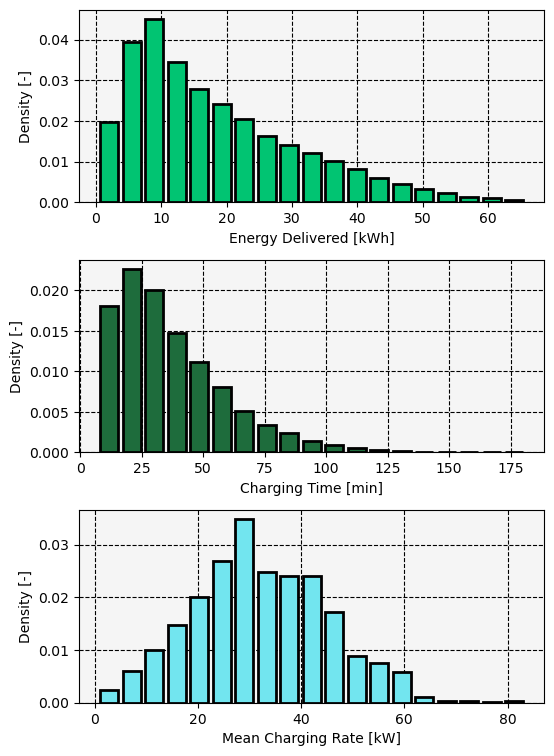

In [135]:
from scipy.stats import rv_histogram

fig, ax = plt.subplots(3, 1, figsize = (6, 9), gridspec_kw = {'hspace': .3})

kw = {
    'density': True,
    'ec': 'k',
    'lw': 2,
    'rwidth': .8,
    'zorder': 3,
}

kw['fc'] = '#01c472'

h = rv_histogram(np.histogram(energy_kwh))

bins = np.linspace(
    h.ppf(.01),
    h.ppf(.99),
    20,
)

ax[0].hist(energy_kwh, bins = bins, **kw)
ax[0].set_xlabel('Energy Delivered [kWh]')

kw['fc'] = '#1e6c3c'

h = rv_histogram(np.histogram(charge_duration * 60))

bins = np.linspace(
    h.ppf(.01),
    h.ppf(.25),
    20,
)

ax[1].hist(charge_duration * 60, bins = bins, **kw)
ax[1].set_xlabel('Charging Time [min]')

kw['fc'] = '#72e5ef'

h = rv_histogram(np.histogram(charge_rate))

bins = np.linspace(
    h.ppf(.01),
    h.ppf(.99),
    20,
)

ax[2].hist(charge_rate, bins = bins, **kw)
ax[2].set_xlabel('Mean Charging Rate [kW]')

kw = {
    'ls': 'dashed',
    'color': 'k',
    'zorder': 0,
}

_ = [ax.grid(**kw) for ax in ax]

kw = {
    'facecolor': 'whitesmoke',
    'ylabel': 'Density [-]',
    'zorder': 0,
}

_ = [ax.set(**kw) for ax in ax]

In [99]:
charge_rate = energy_kwh / charge_duration
charge_rate.mean(), charge_rate.std()

(37.663242018332724, 13.07428290989159)

In [99]:
charge_rate = energy_kwh / charge_duration
charge_rate.mean(), charge_rate.std()

(37.663242018332724, 13.07428290989159)

In [107]:
delta_soc = end_soc - start_soc
battery_size = energy_kwh / delta_soc
battery_size[battery_size == np.inf] = np.nan
np.nanmean(battery_size), np.nanmean(battery_size)

(0.47065779423825443, 0.47065779423825443)

In [112]:
30000 / 240

125.0